In [1]:
import sys
sys.path.insert(1, '../../scripts/')
from s3_support import *

import numpy as np

# load data

## forms

Pull the form ID, organization NTEE segment, and date created. Pulling `datecreated` for data checking to verify data is not out of date.

In [54]:
q = '''select 
            f.id as form,
            f.type as product,
            o.segment as ntee,
            o.state as state,
            f.datecreated as created
        from form as f
            left join organization as o on f.org=o.id'''
forms = redshift_query_read(q, schema='production')

In [55]:
print("{:,} forms".format(len(forms)))
print("{:,} unique IDs".format(len(forms['form'].unique())))
print("date created: {} to {}".format(forms['created'].min(), forms['created'].max()))

108,868 forms
108,868 unique IDs
date created: 2006-05-18 00:00:00 to 2024-03-22 17:46:54


In [56]:
forms.head(2)

,form,product,ntee,state,created
0,14,1,T - Philanthropy; Voluntarism; and Grantmaking,Florida,2007-12-07
1,32,1,None,None,2007-10-10


## transactions

In [7]:
q = '''select
            form,
            date_trunc('week', date) as week,
            count(id) as count_all,
            sum(amount) as vol_all,
            count(distinct(case when recurring=0 then id else null end)) as count_onetime,
            count(distinct(case when recurring_origin=1 then id else null end)) as count_recurring,
            avg(case when recurring=0 then amount else null end) as avg_onetime,
            avg(case when recurring_origin=1 then amount else null end) as avg_recurring
        from transactions
        where status='A' and year >= 2018 and source != 'vt' and source != 'mobilevt'
        group by form, date_trunc('week', date)'''
trans = redshift_query_read(q, schema='production')

In [9]:
print("{:,} entries".format(len(trans)))
print("{:,} unique form's".format(len(trans['form'].unique())))
print("{} - {}".format(trans['week'].min(), trans['week'].max()))

1,161,457 entries
51,449 unique form's
2018-01-01 00:00:00 - 2024-03-25 00:00:00


In [14]:
trans.fillna(0, inplace=True)

In [15]:
trans.tail(2)

,form,week,count_all,vol_all,count_onetime,count_recurring,avg_onetime,avg_recurring
1161455,72,2019-01-28,1,20.0,0,1,0.0,20.0
1161456,1006713,2023-05-29,1,500.0,0,1,0.0,500.0


## traffic

In [10]:
q = '''select
            form,
            date_trunc('week', date) as week,
            sum(views) as pageviews
        from ga
        where date >= 2018
        group by form, date_trunc('week', date)'''
traffic = redshift_query_read(q, schema='production')

In [11]:
print("{:,} traffic entries".format(len(traffic)))
print("{:,} unique form's".format(len(traffic['form'].unique())))
print("{} - {}".format(traffic['week'].min(), traffic['week'].max()))

1,609,316 traffic entries
66,493 unique form's
2018-01-01 00:00:00 - 2024-02-26 00:00:00


In [13]:
traffic.tail(2)

,form,week,pageviews
1609314,1016111,2024-01-08,10
1609315,160834,2019-02-18,4


## merge

In [57]:
df = traffic.merge(trans, on=['form', 'week'], how='left').merge(forms, on=['form'], how='left')

# fill NA's w/ 0
df['count_all'] = df['count_all'].fillna(0)
df['vol_all'] = df['vol_all'].fillna(0)
df['count_onetime'] = df['count_onetime'].fillna(0)
df['count_recurring'] = df['count_recurring'].fillna(0)

# calculate conversion
df['conversion_ot'] = df['count_onetime'] / df['pageviews']
df['conversion_rec'] = df['count_recurring'] / df['pageviews']

In [58]:
len(trans), len(traffic.merge(trans, on=['form', 'week'])), len(traffic.merge(trans, on=['form', 'week'], how='left'))

(1161457, 632099, 1609316)

In [59]:
print("{:,} entries".format(len(df)))
print("{:,} unique form's".format(len(df['form'].unique())))
print("{} - {}".format(df['week'].min(), df['week'].max()))

1,609,316 entries
66,493 unique form's
2018-01-01 00:00:00 - 2024-02-26 00:00:00


We are targeting conversion numbers so we want to omit forms with 0 traffic.

In [61]:
len(df), len(df[df['pageviews']==0]), "{:.2f}%".format((len(df[df['pageviews']==0]) / len(df)) * 100.)

(1609316, 5100, '0.32%')

In [62]:
df = df[df['pageviews']!=0]

In [63]:
df['state'] = df['state'].apply(clean_states)

In [64]:
df.tail(2)

,form,week,pageviews,count_all,vol_all,count_onetime,count_recurring,avg_onetime,avg_recurring,product,ntee,state,created,conversion_ot,conversion_rec
1609314,1016111,2024-01-08,10,0.0,0.0,0.0,0.0,NaN,NaN,4.0,B - Educational Institutions,MS,2023-11-09 14:30:07,0.0,0.0
1609315,160834,2019-02-18,4,0.0,0.0,0.0,0.0,NaN,NaN,1.0,E - Health; General and Rehabilitative,KS,2014-05-06 11:58:34,0.0,0.0


# review

In [65]:
df.drop(['form'], axis=1).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
pageviews,1604216.0,144.392870,5651.764397,1.0,4.0,11.000000,42.000000,2146385.00
count_all,1604216.0,6.345806,60.825951,0.0,0.0,0.000000,2.000000,29171.00
vol_all,1604216.0,795.674157,5897.804213,0.0,0.0,0.000000,176.522500,1750986.23
count_onetime,1604216.0,4.089018,38.543637,0.0,0.0,0.000000,1.000000,23638.00
count_recurring,1604216.0,0.151541,4.326898,0.0,0.0,0.000000,0.000000,2978.00
avg_onetime,630721.0,226.611007,809.760076,0.0,1.0,66.134615,183.250000,100000.00
avg_recurring,630721.0,15.263369,202.326922,0.0,0.0,0.000000,0.000000,61800.00
product,1603580.0,1.298461,0.796107,1.0,1.0,1.000000,1.000000,5.00
conversion_ot,1604216.0,0.206408,3.521088,0.0,0.0,0.000000,0.036364,2230.50
conversion_rec,1604216.0,0.007386,0.140465,0.0,0.0,0.000000,0.000000,62.50


In [66]:
conv_ot = df['conversion_ot'].replace([np.inf, -np.inf], np.nan).dropna().describe()
conv_rec = df['conversion_rec'].replace([np.inf, -np.inf], np.nan).dropna().describe()

pd.DataFrame([conv_ot, conv_rec]).transpose()

,conversion_ot,conversion_rec
count,1.604216e+06,1.604216e+06
mean,2.064079e-01,7.385864e-03
std,3.521088e+00,1.404648e-01
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00
75%,3.636364e-02,0.000000e+00
max,2.230500e+03,6.250000e+01


In [67]:
count_zero = len(df[df['count_all']==0])
traffic_zero = len(df[df['pageviews']==0])
onetime_zero = len(df[df['count_onetime']==0])
rec_zero = len(df[df['count_recurring']==0])

trans_gt_traff = len(df[df['count_all']>df['pageviews']])
rec_gt_ot = len(df[df['count_onetime']<df['count_recurring']])
ottrans_gt_traff = len(df[df['count_onetime']>df['pageviews']])
rectrans_gt_traff = len(df[df['count_recurring']>df['pageviews']])
rectrans_gt_std = len(df[df['count_recurring']>13])

conv_ot_mean = df['conversion_ot'].replace([np.inf, -np.inf], np.nan).dropna().mean()
conv_ot_median = df['conversion_ot'].replace([np.inf, -np.inf], np.nan).dropna().median()
conv_rec_mean = df['conversion_rec'].replace([np.inf, -np.inf], np.nan).dropna().mean()
conv_rec_median = df['conversion_rec'].replace([np.inf, -np.inf], np.nan).dropna().median()
conv_mean = conv_ot_mean + conv_rec_mean
conv_median = conv_ot_median + conv_rec_median

len_all = len(df)

print("Zero transactions: {:,} ({:.1f}%)".format(count_zero, (count_zero / len_all) * 100.))
print("Zero traffic: {:,} ({:.1f}%)".format(traffic_zero, (traffic_zero / len_all) * 100.))
print("Zero one time: {:,} ({:.1f}%)".format(onetime_zero, (onetime_zero / len_all) * 100.))
print("Zero recurring: {:,} ({:.1f}%)".format(rec_zero, (rec_zero / len_all) * 100.))
print()
print("Trans > traffic: {:,} ({:.1f}%)".format(trans_gt_traff, (trans_gt_traff / len_all) * 100.))
print("One time trans > traffic: {:,} ({:.1f}%)".format(ottrans_gt_traff, (ottrans_gt_traff / len_all) * 100.))
print("Recurring trans > traffic: {:,} ({:.1f}%)".format(rectrans_gt_traff, (rectrans_gt_traff / len_all) * 100.))
print("Recurring trans > one time: {:,} ({:.1f}%)".format(rec_gt_ot, (rec_gt_ot / len_all) * 100.))
print("Recurring trans > std: {:,} ({:.1f}%)".format(rectrans_gt_std, (rectrans_gt_std / len_all) * 100.))
print()
print("Conversion mean: {:.2f}%".format(conv_mean * 100.))
print("Conversion median: {:.2f}%".format(conv_median * 100.))
print("Conversion one time mean: {:.2f}%".format(conv_ot_mean * 100.))
print("Conversion one time median: {:.2f}%".format(conv_ot_median * 100.))
print("Conversion recurring mean: {:.2f}%".format(conv_rec_mean * 100.))
print("Conversion recurring median: {:.2f}%".format(conv_rec_median * 100.))

Zero transactions: 973,495 (60.7%)
Zero traffic: 0 (0.0%)
Zero one time: 1,101,621 (68.7%)
Zero recurring: 1,520,391 (94.8%)

Trans > traffic: 85,748 (5.3%)
One time trans > traffic: 41,877 (2.6%)
Recurring trans > traffic: 1,107 (0.1%)
Recurring trans > one time: 21,334 (1.3%)
Recurring trans > std: 2,099 (0.1%)

Conversion mean: 21.38%
Conversion median: 0.00%
Conversion one time mean: 20.64%
Conversion one time median: 0.00%
Conversion recurring mean: 0.74%
Conversion recurring median: 0.00%


<AxesSubplot:xlabel='state'>

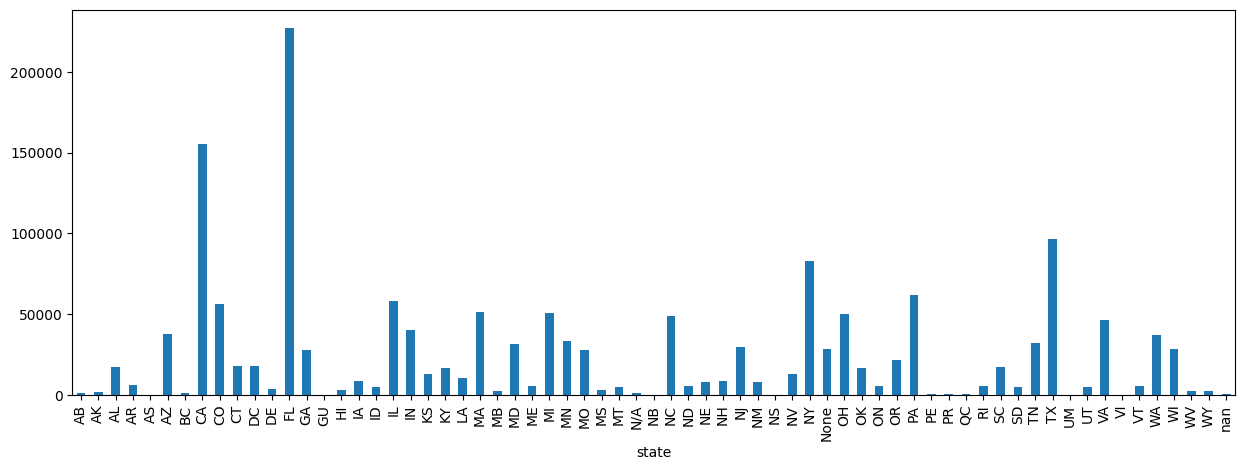

In [73]:
df.groupby('state')['form'].count().plot(kind='bar', figsize=(15,5))

In [70]:
#df.to_csv("seg_state.forms.csv", index=False)